Heart Disease Report 

In [21]:
library(tidyverse) 
library(tidymodels)
library(gridExtra)
options(repr.matrix.max.rows = 6)
url <-"https://raw.githubusercontent.com/katelynmilan/DSCI_project/main/processed.cleveland.data"
data_set <- read_csv(url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))
data_set

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [22]:
 clean_data <- data_set|> 
select(age, sex, chol, num) |> 
rename(Heart_Disease = num, Cholesterol = chol, Age = age, Sex = sex)|>
mutate(Heart_Disease = as.character(Heart_Disease))   

data_split <- initial_split(clean_data, prop = 0.75, strata = Heart_Disease)
data_train <- training(data_split)
data_test <- testing(data_split)

data_train  



Age,Sex,Cholesterol,Heart_Disease
<dbl>,<dbl>,<dbl>,<chr>
63,1,233,0
37,1,250,0
41,0,204,0
⋮,⋮,⋮,⋮
55,0,205,3
59,1,176,3
57,1,131,3


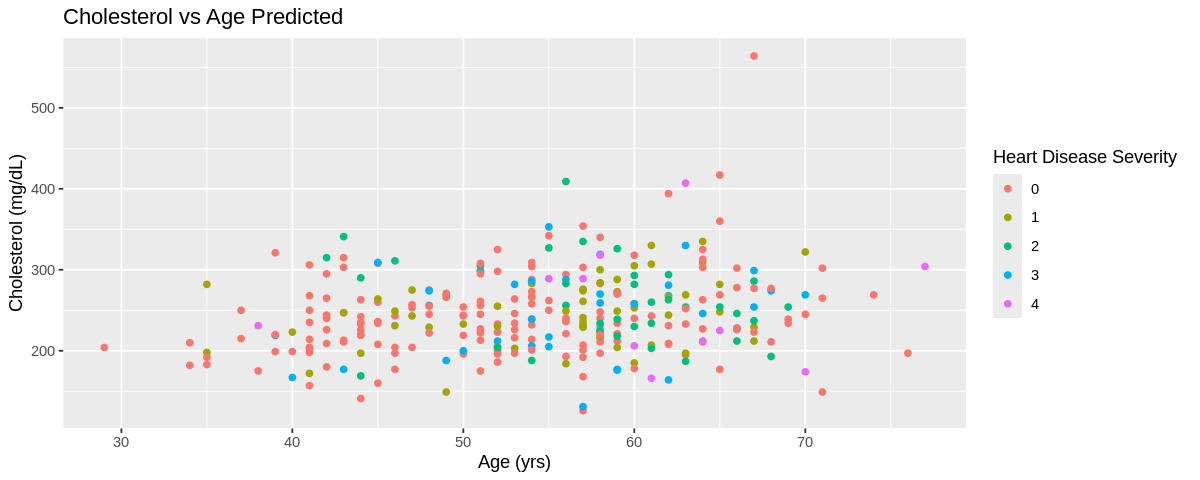

In [26]:
heart_exploratory_data_plot <- ggplot(clean_data, aes(x = age, y = cholesterol))+
                geom_point(aes(color = heart_disease))+
                labs(x = "Age (yrs)", y = "Cholesterol (mg/dL)", color = "Heart Disease Severity")+
                ggtitle("Cholesterol vs Age Predicted")  
heart_exploratory_data_plot

In [27]:
set.seed(42069)

clean_data <- data_set|> 
select(age, chol, num) |> 
rename(heart_disease = num, cholesterol = chol, age = age)|>
mutate(heart_disease = as.factor(heart_disease))   

data_split <- initial_split(clean_data, prop = 0.75, strata = heart_disease)
data_train <- training(data_split)
data_test <- testing(data_split)

heart_recipe <- recipe(heart_disease ~ age + cholesterol, data = clean_data)|>
                    step_scale(all_predictors())|>
                    step_center(all_predictors())

heart_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
            set_engine("kknn")|>
            set_mode("classification")

heart_workflow <- workflow()|>
                    add_model(heart_model)|>
                    add_recipe(heart_recipe)

heart_vfold <- vfold_cv(data_train, v = 5, strata = heart_disease)

grid_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

best_k <- heart_workflow |>
            tune_grid(resamples = heart_vfold, grid = grid_vals)|>
            collect_metrics()|>
            filter(.metric == "accuracy")|>
            slice_min(mean, n = 1)

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2)|>
            set_engine("kknn")|>
            set_mode("classification")

knn_fit <- workflow()|>
            add_model(heart_spec)|>
            add_recipe(heart_recipe)|>
            fit(data = data_train)

heart_pred <- knn_fit |> 
           predict(data_test) |>
           bind_cols(data_test)
           

heart_pred

.pred_class,age,cholesterol,heart_disease
<fct>,<dbl>,<dbl>,<fct>
0,41,204,0
1,62,268,3
0,57,354,0
⋮,⋮,⋮,⋮
0,63,187,2
0,68,193,2
3,38,175,0


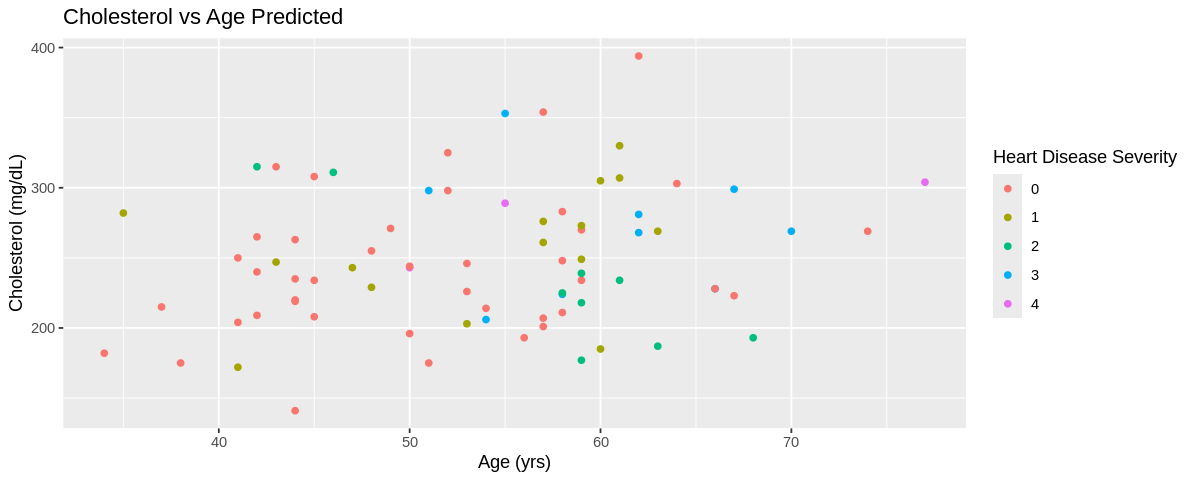

In [25]:
options(repr.plot.height = 4, repr.plot.width = 10)
heart_pred_plot <- ggplot(heart_pred, aes(x = age, y = cholesterol))+
                geom_point(aes(color = heart_disease))+
                labs(x = "Age (yrs)", y = "Cholesterol (mg/dL)", color = "Heart Disease Severity")+
                ggtitle("Cholesterol vs Age Predicted") 
heart_pred_plot

Methods: A heart disease dataset found online was wrangled and cleaned before nearest neighbors classification was used to predict heart disease severity. A scatterplot was then made to depict the data before begining analysis.  Data was split into 75% training data, which was verified using 5 fold cross validation. A recipe was created to predict the heart disease severity based on age and cholesterol. Best K value was determined and used in the k nearest neighbors classification algorithm. The prediction was then ran and accuracy of the predictor was determined. Finally a visulixation of the analysis was made.  

Discussion:  After analysis of the data, it was found that there was no clear relationship between, age, cholesterol and heart disease severity. Given the previous research, it demonstrates how age and cholesterol are contributing factors to the severity of heart disease therefore we also expected to find this in our data. However, this is not what was found. These findings could have an impact on many people and it's of importance due to its correlation with health. Having such knowledge can educate people to be more cautious and alert them to the ways to prevent heart disease. Further questions this research has led to would be: how many more variables would we have to add before our preditor had high enough accuracy to be reliable?